In [1]:
# Install the required libraries in your Google Colab environment
!pip install stable-baselines3 gymnasium highway-env -q

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 183.9/183.9 kB 2.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 958.1/958.1 kB 17.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 105.0/105.0 kB 3.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 363.4/363.4 MB 1.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 13.8/13.8 MB 71.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 24.6/24.6 MB 51.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 883.7/883.7 kB 33.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 664.8/664.8 MB 1.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 211.5/211.5 MB 4.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 56.3/56.3 MB 11.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 127.9/127.9 MB 7.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 207.5/207.5 MB 6.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━

In [2]:
# Import the necessary libraries
import gymnasium as gym
import highway_env
import numpy as np
import pandas as pd
import pickle
import os
import matplotlib.pyplot as plt

In [3]:
from stable_baselines3 import PPO
from stable_baselines3.common.vec_env import DummyVecEnv
from stable_baselines3.common.evaluation import evaluate_policy
from stable_baselines3.common.monitor import Monitor
from google.colab import data_table
from google.colab import drive

# Mount Google Drive
drive.mount('/content/drive')

Mounted at /content/drive


In [4]:
# Load the dataframe back from the pickle file
trajectory_df = pd.read_pickle('/content/drive/MyDrive/data_rp1/2_trajectories/0_initial_training/0_initial_trajectory_df.pkl')

In [5]:
# Display the data frame
data_table.enable_dataframe_formatter()
data_table.DataTable(trajectory_df)

Output hidden; open in https://colab.research.google.com to view.

In [6]:
# Check the data type of each column
print(type(trajectory_df['episode'][0]))
print(type(trajectory_df['time_step'][0]))
print(type(trajectory_df['state'][0]))
print(type(trajectory_df['action'][0]))
print(type(trajectory_df['reward'][0]))
print(type(trajectory_df['next_state'][0]))
print(type(trajectory_df['collision_flag'][0]))
print(type(trajectory_df['lane_index'][0]))

<class 'numpy.int64'>
<class 'numpy.int64'>
<class 'numpy.ndarray'>
<class 'numpy.ndarray'>
<class 'numpy.float64'>
<class 'numpy.ndarray'>
<class 'numpy.int64'>
<class 'numpy.int64'>


In [7]:
trajectory_df.dtypes

,0
episode,int64
time_step,int64
state,object
action,object
reward,float64
next_state,object
collision_flag,int64
lane_index,int64


A : HUMAN FEEDBACK IMPLEMENTATION (IDEAL CASE SCENARIO)
*   SECTION A.1: FEEDBACK BASED ON LANE CHANGING BEHAVIOUR
*   SECTION A.2: FEEDBACK BASED ON COLLISION AVOIDANCE MANUEVERS
*   SECTION A.3: FEEDBACK BASED ON SPEED OPTIMIZATION
*   SECTION A.4: REWARD MODELLING
*   SECTION A.5: MODEL TRAINING


SECTION A.1: FEEDBACK BASED ON LANE CHANGING BEHAVIOUR
*   Step A.1.1: FUNCTION TO COUNT LANE CHANGES
*   Step A.1.2: FUNCTION TO PROVIDE FEEDBACK BASED ON LANE CHANGE


In [8]:
# Step A.1.1: FUNCTION TO COUNT LANE CHANGES
def count_lane_changes(df):
    df_copy = df.copy()
    df_copy['count_lane_change'] = 0

    # Group by episode
    for episode_id, episode_df in df_copy.groupby('episode'):  # Group by 'episode'
        idx = 0
        while idx < len(episode_df):  # Iterate within each episode
            current_lane_index = episode_df.iloc[idx]['lane_index']

            if idx == 0:  # First timestep of the episode
                episode_df.at[episode_df.index[idx], 'count_lane_change'] = 0 #  Use episode_df.index[idx]
                idx += 1
                continue

            previous_lane_index = episode_df.iloc[idx - 1]['lane_index']

            if current_lane_index == previous_lane_index:
                episode_df.at[episode_df.index[idx], 'count_lane_change'] = 0 #  Use episode_df.index[idx]
                idx += 1
                continue

            change = current_lane_index - previous_lane_index
            count = 1
            consecutive_indices = [idx]

            lookahead_idx = idx + 1
            while lookahead_idx < len(episode_df) and (episode_df.iloc[lookahead_idx]['lane_index'] - episode_df.iloc[lookahead_idx - 1]['lane_index'] == change):
                count += 1
                consecutive_indices.append(lookahead_idx)
                lookahead_idx += 1

            for i in consecutive_indices:
                episode_df.at[episode_df.index[i], 'count_lane_change'] = count #  Use episode_df.index[i]

            idx = lookahead_idx

        df_copy.loc[episode_df.index, 'count_lane_change'] = episode_df['count_lane_change'].values # Update original df

    return df_copy

In [9]:
# Call the function and save the updated dataframe as "lane_feedback_df"
lane_feedback_df = count_lane_changes(trajectory_df)

In [10]:
data_table.enable_dataframe_formatter()
data_table.DataTable(lane_feedback_df)

Output hidden; open in https://colab.research.google.com to view.

In [11]:
# Step A.1.2: FUNCTION TO PROVIDE FEEDBACK BASED ON LANE CHANGE
# Define the lane_change_behaviour function
def lane_change_behaviour(df):
    # Create a copy of the dataframe to avoid modifying the original one
    df_copy = df.copy()

    # Create 'Lane_feedback' and 'Lane_change_reward' columns
    df_copy['Lane_feedback'] = ""
    df_copy['Lane_change_score'] = 0
    df_copy['Lane_change_score'] = df_copy['Lane_change_score'].astype(float)

    # Iterate through the dataframe to apply the lane change behavior logic
    for i, row in df_copy.iterrows():
        lane_change_number = row['count_lane_change']

        if lane_change_number == 0:
            df_copy.at[i, 'Lane_feedback'] = "No lane change is observed"
            df_copy.at[i, 'Lane_change_score'] = +2                                 # Bias value 1
        elif lane_change_number == 1:
            df_copy.at[i, 'Lane_feedback'] = "One lane change is observed"
            df_copy.at[i, 'Lane_change_score'] = 0                                  # Bias value 2
        elif lane_change_number == 2:
            df_copy.at[i, 'Lane_feedback'] = "Two lane change is observed"
            df_copy.at[i, 'Lane_change_score'] = -1                                 # Bias value 3
        elif lane_change_number == 3:
            df_copy.at[i, 'Lane_feedback'] = "Three lane change is observed"
            df_copy.at[i, 'Lane_change_score'] = -2                                 # Bias value 4


    # Return the updated dataframe
    return df_copy

In [12]:
# Apply the lane_change_behaviour function to the lane_feedback_df
lane_behaviour_feedback_df = lane_change_behaviour(lane_feedback_df)

In [13]:
data_table.enable_dataframe_formatter()
data_table.DataTable(lane_behaviour_feedback_df)

Output hidden; open in https://colab.research.google.com to view.

SECTION A.2: FEEDBACK BASED ON COLLISION AVOIDANCE MANUEVERS
*   Step A.2.1: FUNCTION TO CALCULATE LANE CHANG
*   Step A.2.2: FUNCTION TO CALCULATE TIME TO COLLISION(TTC)
*   Step A.2.3: FUNCTION TO CALCULATE RELATIVE POSITION, RELATIVE VELOCITY AND TIME TO COLLISION
*   Step A.2.4: FUNCTION TO IMPLEMENT COLLISION AVOIDANCE FEEDBACK

In [14]:
def calculate_lane_changes(df):
    df_copy = df.copy()
    df_copy['Lane_change_collision_fb'] = 0

    # Group by episode
    for episode_id, episode_df in df_copy.groupby('episode'):  # Group by 'episode'
        idx = 0
        while idx < len(episode_df):  # Iterate within each episode
            current_lane_index = episode_df.iloc[idx]['lane_index']

            if idx == 0:  # First timestep of the episode
                episode_df.at[episode_df.index[idx], 'Lane_change_collision_fb'] = 0 #  Use episode_df.index[idx]
                idx += 1
                continue

            previous_lane_index = episode_df.iloc[idx - 1]['lane_index']

            if current_lane_index != previous_lane_index:
                episode_df.at[episode_df.index[idx], 'Lane_change_collision_fb'] = 1 #  Use episode_df.index[idx]
                idx += 1
                continue

            else:
                episode_df.at[episode_df.index[idx], 'Lane_change_collision_fb'] = 0 #  Use episode_df.index[idx]
                idx += 1

        df_copy.loc[episode_df.index, 'Lane_change_collision_fb'] = episode_df['Lane_change_collision_fb'].values # Update original df
        # df_copy.loc[episode_df.index, 'count_lane_change'] = episode_df['count_lane_change'].values

    return df_copy

In [15]:
# Call the function and save the updated dataframe as "lane_feedback_df"
lane_change_collision_fb_df = calculate_lane_changes(trajectory_df)

In [16]:
data_table.enable_dataframe_formatter()
data_table.DataTable(lane_change_collision_fb_df)

Output hidden; open in https://colab.research.google.com to view.

In [17]:
 # Step A.2.2: FUNCTION TO CALCULATE TIME TO COLLISION(TTC)
def calculate_ttc(ego_vehicle, other_vehicles):
    if not other_vehicles:
        return np.inf, -1  # No other vehicles

    min_ttc = np.inf
    nearest_vehicle_index = -1

    ego_x = ego_vehicle["x"]
    ego_y = ego_vehicle["y"]
    ego_vx = ego_vehicle["vx"]
    ego_vy = ego_vehicle["vy"]

    for i, other in enumerate(other_vehicles):
        other_x = other["x"]
        other_y = other["y"]
        other_vx = other["vx"]
        other_vy = other["vy"]

        dx = other_x - ego_x
        dy = other_y - ego_y

        # Use magnitude and heading if vx/vy not directly available
        # v_ego = np.sqrt(ego_vx**2 + ego_vy**2)
        # heading_ego = ...  # Get heading angle
        # v_other = np.sqrt(other_vx**2 + other_vy**2)
        # heading_other = ... # Get heading angle

        dvx = other_vx - ego_vx
        dvy = other_vy - ego_vy

        # Calculate TTC (constant velocity assumption)
        # More robust calculation considering angle between vehicles:
        dot_product = dx * dvx + dy * dvy
        if dot_product < 0:  # Vehicles are getting closer
            distance = np.sqrt(dx**2 + dy**2)
            relative_speed = np.sqrt(dvx**2 + dvy**2)  # Magnitude of relative speed
            if relative_speed > 0:
              ttc = distance / relative_speed
            else:
              ttc = np.inf # Relative speed is zero, no collision
        else:
            ttc = np.inf  # Vehicles are moving apart


        if ttc < min_ttc and ttc > 0: # Only consider positive TTCs (collisions)
            min_ttc = ttc
            nearest_vehicle_index = i

    return min_ttc, nearest_vehicle_index

In [18]:
#  Step A.2.3: FUNCTION TO CALCULATE RELATIVE POSITION, RELATIVE VELOCITY AND ACCELARATION

def calculate_collision_parameters_1(trajectory_df):
    # Create a copy of the original dataframe
    df_copy = trajectory_df.copy()

    df_copy['Nearest vehicle id'] = None
    df_copy['TTC'] = 0.0
    # Create a new column for storing collision parameters
    df_copy['Collision_Parameters'] = None

    # Group by episode
    for episode_id, episode_df in df_copy.groupby('episode'):
        # Iterate through each timestep in the episode
        for idx, row in episode_df.iterrows():
            # Get the agent's state and new state
            agent_state = row['state']
            agent_new_state = row['next_state']

            agent_position = np.array([agent_state[1], agent_state[2]])  # x, y
            agent_velocity = np.array([agent_state[3], agent_state[4]])  # vx, vy
            agent_new_position = np.array([agent_new_state[1], agent_new_state[2]])  # new x, new y
            agent_new_velocity = np.array([agent_new_state[3], agent_new_state[4]])  # new vx, new vy

            # Find the nearest vehicle
            nearest_vehicle_distance = float('inf')
            nearest_vehicle_idx = None
            other_vehicles = [] # Initialize list to store other vehicles' data
            for vehicle_idx, vehicle_row in episode_df.iterrows():
                if vehicle_idx != idx:  # Skip the agent itself
                    vehicle_state = vehicle_row['state']
                    vehicle_position = np.array([vehicle_state[1], vehicle_state[2]])
                    vehicle_velocity = np.array([vehicle_state[3], vehicle_state[4]]) # Added to store velocity
                    distance = np.linalg.norm(agent_position - vehicle_position)
                    if distance < nearest_vehicle_distance:
                        nearest_vehicle_distance = distance
                        nearest_vehicle_idx = vehicle_idx
                    other_vehicles.append({"x": vehicle_position[0], "y": vehicle_position[1], "vx":vehicle_velocity[0], "vy":vehicle_velocity[1]}) # Added other vehicles

            # print(f"Episode {episode_id}, Time step {row['time_step']}: Nearest vehicle is {nearest_vehicle_idx}")

            if nearest_vehicle_idx is None:
                collision_data = {
                    'Vehicle_number': None,
                    'Relative_position': None,
                    'Relative_velocity': None,
                    'Relative_speed': None,
                    'TTC': None,
                    'Agent_acceleration': None
                }
                df_copy.at[row.name, 'Collision_Parameters'] = collision_data
                continue

            # --- TTC Calculation Logic (Modified) ---
            ego_vehicle = {"x": agent_position[0], "y": agent_position[1], "vx": agent_velocity[0], "vy": agent_velocity[1]}
            ttc, _ = calculate_ttc(ego_vehicle, other_vehicles) # Call the function

            # --- End of TTC Calculation Logic ---

            nearest_vehicle_state = episode_df.loc[nearest_vehicle_idx, 'state']
            nearest_vehicle_position = np.array([nearest_vehicle_state[1], nearest_vehicle_state[2]])
            nearest_vehicle_velocity = np.array([nearest_vehicle_state[3], nearest_vehicle_state[4]])

            relative_position = nearest_vehicle_position - agent_position
            relative_velocity = nearest_vehicle_velocity - agent_velocity
            relative_speed = np.linalg.norm(relative_velocity)


            acceleration = agent_new_velocity - agent_velocity

            collision_data = {
                'Vehicle_number': nearest_vehicle_idx,
                'Relative_position': relative_position.tolist(),
                'Relative_velocity': relative_velocity.tolist(),
                'Relative_speed': relative_speed,
                'TTC': ttc,
                'Agent_acceleration': acceleration.tolist()
            }
            df_copy.at[row.name, 'Collision_Parameters'] = collision_data
            df_copy.at[row.name, 'Nearest vehicle id'] = nearest_vehicle_idx
            df_copy.at[row.name, 'TTC'] = ttc

    return df_copy

In [19]:
collision_parameters_df_1 = calculate_collision_parameters_1(lane_change_collision_fb_df)

In [20]:
data_table.enable_dataframe_formatter()
data_table.DataTable(collision_parameters_df_1)

Output hidden; open in https://colab.research.google.com to view.

In [21]:
## Time to collision list
## Group the data by 'episode'
# episode_data = collision_parameters_df_1.groupby('episode')
## Loop through each episode
# for episode, data in episode_data:
#    # Extract lane indices
#     ttc_list = data['TTC'].tolist()

#    # Count the total number of time steps in the episode
#     total_timesteps = data['time_step'].max() + 1  # Assuming time_step starts from 0

#     print(f"Episode {episode}:Total timesteps {total_timesteps}: {ttc_list}")

In [22]:
## List of nearest vehicles
## Group the data by 'episode'
# episode_data = collision_parameters_df_1.groupby('episode')
## Loop through each episode
# for episode, data in episode_data:
#     # Extract lane indices
#     nearest_vehicle_list = data['Nearest vehicle id'].tolist()

#     # Count the total number of time steps in the episode
#     total_timesteps = data['time_step'].max() + 1  # Assuming time_step starts from 0

#     print(f"Episode {episode}:Total timesteps {total_timesteps}: {nearest_vehicle_list}")

In [23]:
# Step A.2.4: Function to implement collision avoidance feedback
def implement_collision_feedback(df):
    # Create a copy of the dataframe to avoid modifying the original dataframe
    df_copy = df.copy()

    # Create new columns for Collision Feedback and Collision Reward
    df_copy['Collision_Feedback'] = None
    df_copy['Collision_score'] = 0.0

    # Iterate through each timestep in the dataframe
    for idx, row in df_copy.iterrows():
        collision_data = row['Collision_Parameters']
        ttc = collision_data['TTC']
        agent_acceleration = collision_data['Agent_acceleration']
        lane_change = row['Lane_change_collision_fb']

        # Initialize feedback and reward
        feedback = ''
        feedback_1 = ''
        score = 0.0

        # Logic for Time to Collision (TTC)
        if  0.5 <= ttc <=2.0 :
            feedback_1 = 'Potential collision risk'
            if agent_acceleration[0] < 0:
                feedback = 'Avoided collision by slowing down'
                score = +1                                                          # Bias Value 5
            elif agent_acceleration[0] > 0:
                feedback = 'Avoided collision by speeding up'
                score = 0                                                           # Bias Value 6
            elif lane_change == 1:
                feedback = 'Avoided collision by lane change'
                score = +1                                                          # Bias Value 7
        elif ttc < 0.5:
            feedback_1 = 'Immediate collision risk'
            # Check if agent_acceleration is not [0, 0] using any
            # Modified: Check if any element in agent_acceleration is not 0
            if any(x != 0 for x in agent_acceleration):
            # if agent_acceleration != [0, 0]:
                feedback = 'Emergency avoidance'
                score = -2                                                          # Bias Value 8
            else:
                score = 0.0
        else:
            feedback = 'Safe Path'
            score = +2                                                              # Bias Value 9

        # Update the feedback and reward columns
        df_copy.at[idx, 'Collision_Feedback'] = feedback_1, feedback
        df_copy.at[idx, 'Collision_score'] = score

    return df_copy

In [24]:
# Call the function to process collision feedback and reward
Collision_feedback_df = implement_collision_feedback(collision_parameters_df_1)

In [25]:
data_table.enable_dataframe_formatter()
data_table.DataTable(Collision_feedback_df)

Output hidden; open in https://colab.research.google.com to view.

SECTION A.3: FEEDBACK BASED ON SPEED OPTIMIZATION
*   Step A.3.1: FUNCTION TO CALCULATE AGENT SPEED AND TRAFFIC DENSITY SCORE
*   Step A.3.2: FUNCTION TO IMPLEMENT SPEED OPTIMIZATION FEEDBACK

In [26]:
# Step A.3.1: FUNCTION TO CALCULATE AGENT SPEED AND TRAFFIC DENSITY SCORE
# Define the function to calculate agent speed and traffic density score
def calculate_speed_and_traffic_density(trajectory_df):
    # Create a copy of the input dataframe to avoid modifying the original
    df = trajectory_df.copy()

    df['Average_distance'] = 0.0
    df['Traffic_density_score'] = 0
    df['Agent_Speed'] = 0
    # Initialize the Speed_Optimization_Parameters column
    df['Speed_Optimization_Parameters'] = None


    # Function to calculate agent speed based on vx and vy (longitudinal and lateral velocities)
    def calculate_speed(vx, vy):
        return np.sqrt(vx**2 + vy**2)

    # Iterate through the rows of the dataframe to calculate the required values
    for index, row in df.iterrows():
        # Extract agent state and next state
        state = row['state']
        next_state = row['next_state']

        # Extract agent vehicle's (ego vehicle) longitudinal and lateral velocity
        agent_vx = state[3]  # vx of agent
        agent_vy = state[4]  # vy of agent

        # Calculate agent speed
        agent_speed = calculate_speed(agent_vx, agent_vy)

        # Extract other vehicles' state
        # The original state is a flattened array of shape (25,).
        # We need to reshape it to (5, 5) to represent 5 vehicles, each with 5 attributes.
        # Then we can select the other vehicles (excluding the ego vehicle at index 0).

        state_reshaped = state.reshape(5, 5)  # Reshape to 5 vehicles, 5 features each
        other_vehicles_state = state_reshaped[1:]  # Exclude ego vehicle (index 0)


        # Extract other vehicles' state
        # other_vehicles_state = state[1:].reshape(-1, 5)  # Extract all other vehicles' states

        # Calculate the distances between the agent and other vehicles
        distances = []
        for vehicle in other_vehicles_state:
            # Calculate the distance between the agent and other vehicles using x and y positions
            vehicle_x, vehicle_y = vehicle[1], vehicle[2]
            agent_x, agent_y = state[1], state[2]
            distance = np.sqrt((vehicle_x - agent_x)**2 + (vehicle_y - agent_y)**2)
            distances.append(distance)
            # print(f"Distance between agent and vehicle {index}: {distance}")

        # Determine traffic density score based on the distance
        traffic_density_score = 1  # Default low traffic density (1)
        avg_distance = np.mean(distances)
        #print(f"Average distance between agent and other vehicles: {avg_distance}")

        if avg_distance < 0.8:  # High traffic density
            traffic_density_score = 3
        elif avg_distance < 1.0:  # Medium traffic density
            traffic_density_score = 2

        df.at[index, 'Average_distance'] = avg_distance
        df.at[index, 'Traffic_density_score'] = traffic_density_score
        df.at[index, 'Agent_Speed'] = agent_speed
        # Add the agent speed and traffic density score to the 'Speed_Optimization_Parameters' column
        df.at[index, 'Speed_Optimization_Parameters'] = {'Agent_Speed': agent_speed, 'Traffic_Density_Score': traffic_density_score}


    return df


In [27]:
# Call the function to calculate speed and traffic density
Speed_parameters_df = calculate_speed_and_traffic_density(trajectory_df)

<ipython-input-26-1eea890ac805>:65: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise an error in a future version of pandas. Value '0.3125' has dtype incompatible with int64, please explicitly cast to a compatible dtype first.
  df.at[index, 'Agent_Speed'] = agent_speed


In [28]:
data_table.enable_dataframe_formatter()
data_table.DataTable(Speed_parameters_df)

Output hidden; open in https://colab.research.google.com to view.

In [29]:
## Distance between vehicles list
## Group the data by 'episode'
# episode_data = Speed_parameters_df.groupby('episode')
## Loop through each episode
# for episode, data in episode_data:
#    # Extract lane indices
#     average_distance_list = data['Average_distance'].tolist()

#    # Count the total number of time steps in the episode
#     total_timesteps = data['time_step'].max() + 1  # Assuming time_step starts from 0

#     print(f"Episode {episode}:Total timesteps {total_timesteps}: {average_distance_list}")

In [30]:
## Traffic density score
## Group the data by 'episode'
# episode_data = Speed_parameters_df.groupby('episode')
## Loop through each episode
# for episode, data in episode_data:
#    # Extract lane indices
#     traffic_density_score_list = data['Traffic_density_score'].tolist()

#    # Count the total number of time steps in the episode
#     total_timesteps = data['time_step'].max() + 1  # Assuming time_step starts from 0

#     print(f"Episode {episode}:Total timesteps {total_timesteps}: {traffic_density_score_list}")

In [31]:
## Agent's speed for each episode
## Group the data by 'episode'
# episode_data = Speed_parameters_df.groupby('episode')
## Loop through each episode
# for episode, data in episode_data:
#    # Extract lane indices
#    agent_speed_list = data['Agent_Speed'].tolist()

#    # Count the total number of time steps in the episode
#    total_timesteps = data['time_step'].max() + 1  # Assuming time_step starts from 0

#    print(f"Episode {episode}:Total timesteps {total_timesteps}: {agent_speed_list}")

In [32]:
# Step A.3.2: FUNCTION TO IMPLEMENT SPEED OPTIMIZATION FEEDBACK
def implement_speed_optimization_feedback(Speed_parameters_df):
    # Create a copy of the dataframe to avoid modifying the original
    df_copy = Speed_parameters_df.copy()

    # Define the threshold_speed range
    threshold_speed_min = 0.25  # Example minimum threshold speed
    threshold_speed_max = 0.30  # Example maximum threshold speed
    threshold_speed = (threshold_speed_min, threshold_speed_max)  # Tuple representing min and max speeds

    # Initialize columns for feedback and reward
    speed_optimization_feedback = []
    speed_optimization_score = []

    # Iterate through the dataframe to calculate feedback and rewards
    for i in range(len(df_copy)):
        # Extract the agent speed and traffic density from the Speed_Optimization_Parameters
        # agent_speed = df_copy['Speed_Optimization_Parameters']['Agent_Speed']
        # traffic_density = df_copy['Speed_Optimization_Parameters']['Traffic_density_score']
        agent_speed = df_copy['Speed_Optimization_Parameters'][i]['Agent_Speed']
        traffic_density = df_copy['Speed_Optimization_Parameters'][i]['Traffic_Density_Score']

        feedback = ""
        score = 0.0

        # Check traffic density and apply corresponding logic
        if traffic_density == 1:  # Low traffic density
            if agent_speed > threshold_speed[1]:
                feedback = "Low risk, High Speed-Optimization"
                score = +2                                                          # Bias Value 10
            elif threshold_speed[0] <= agent_speed <= threshold_speed[1]:
                feedback = "Low risk, moderate Speed-Optimization"
                score = +1                                                          # Bias Value 11
            else:  # agent_speed < threshold_speed[0]
                feedback = "Low risk, Low Speed-Optimization"
                score = -1                                                          # Bias Value 12

        elif traffic_density == 2:  # Medium traffic density
            if agent_speed > threshold_speed[1]:
                feedback = "Moderate risk, High Speed-Optimization"
                score = -1                                                          # Bias Value 13
            elif threshold_speed[0] <= agent_speed <= threshold_speed[1]:
                feedback = "Moderate risk, moderate Speed-Optimization"
                score = +2                                                          # Bias Value 14
            else:  # agent_speed < threshold_speed[0]
                feedback = "Moderate risk, Low Speed-Optimization"
                score = -1                                                          # Bias Value 15

        elif traffic_density == 3:  # High traffic density
            if agent_speed > threshold_speed[1]:
                feedback = "High risk, High Speed-Optimization"
                score = -2                                                          # Bias Value 16
            elif threshold_speed[0] <= agent_speed <= threshold_speed[1]:
                feedback = "High risk, moderate Speed-Optimization"
                score = -1                                                          # Bais Value 17
            else:  # agent_speed < threshold_speed[0]
                feedback = "High risk, Low Speed-Optimization"
                ascore = +2                                                          # Bias Value 18

        # Append the feedback and reward to the respective lists
        speed_optimization_feedback.append(feedback)
        speed_optimization_score.append(score)

    # Add the new columns to the dataframe
    df_copy['Speed_Optimization_Feedback'] = speed_optimization_feedback
    df_copy['Speed_Optimization_score'] = speed_optimization_score

    return df_copy

In [33]:
Speed_optimization_feedback_df = implement_speed_optimization_feedback(Speed_parameters_df)

In [34]:
data_table.enable_dataframe_formatter()
data_table.DataTable(Speed_optimization_feedback_df)

Output hidden; open in https://colab.research.google.com to view.

SECTION- A.4: REWARD MODELLING(HUMAN FEEDBACK)
*   Step A.4.1: COMBINING HUMAN FEEDBACK AND CALCULATING ADJUSTED REWARDS
*   Step A.4.2: RECALIBRATE REWARDS BASED ON SIMULATED HUMAN FEEDBACK

In [35]:
# Step A.4.1: COMBINING HUMAN FEEDBACK AND CALCULATING ADJUSTED REWARDS
# Function to combine data from four dataframes and merge with trajectory_df
def combine_feedback_and_rewards(trajectory_df, collision_feedback_df, speed_optimization_feedback_df, lane_behaviour_feedback_df):
    # Create a copy of the trajectory_df to avoid modifying the original one
    df_copy = trajectory_df.copy()

    # Convert the 'Collision_Feedback' column to strings
    #collision_feedback_df['Collision_Feedback'] = collision_feedback_df['Collision_Feedback'].apply(lambda x:''.join(map(str, x)))
    collision_feedback_df['Collision_Feedback'] = collision_feedback_df['Collision_Feedback'].astype(str)


    # Combine the 'Feedback' columns from the four dataframes and add to the 'Simulated_human_feedback' column
    df_copy['Simulated_human_feedback'] = (
        collision_feedback_df['Collision_Feedback'] + ";" +
        speed_optimization_feedback_df['Speed_Optimization_Feedback'] + ";" +
        lane_behaviour_feedback_df['Lane_feedback']
    )

    # Add the values of the 'Reward' columns from the four dataframes and store the result in 'Adjusted_score' column
    df_copy['Adjusted_score'] = (
        collision_feedback_df['Collision_score'] +
        speed_optimization_feedback_df['Speed_Optimization_score'] +
        lane_behaviour_feedback_df['Lane_change_score']
    )

    # Return the updated dataframe
    return df_copy

In [36]:
# Call the function to combine feedback and calculate adjusted rewards
simulated_human_feedback_df = combine_feedback_and_rewards(
    trajectory_df,
    Collision_feedback_df,
    Speed_optimization_feedback_df,
    lane_behaviour_feedback_df
)

In [37]:
data_table.enable_dataframe_formatter()
data_table.DataTable(simulated_human_feedback_df)

Output hidden; open in https://colab.research.google.com to view.

In [38]:
## List of adjusted scores for each episode
## Group the data by 'episode'
# episode_data = simulated_human_feedback_df.groupby('episode')
## Loop through each episode
# for episode, data in episode_data:
#    # Extract lane indices
#     adjusted_score_list = data['Adjusted_score'].tolist()

#     # Count the total number of time steps in the episode
#     total_timesteps = data['time_step'].max() + 1  # Assuming time_step starts from 0

#     print(f"Episode {episode}:Total timesteps {total_timesteps}: {adjusted_score_list}")

In [39]:
# Step A.4.2: RECALIBRATE REWARDS BASED ON SIMULATED HUMAN FEEDBACK
# Function to recalibrate the rewards
def recalibrate_rewards(df):
    # Create a copy of the dataframe
    df_copy = df.copy()

    # Create the 'Recalibrated_rewards' column
    df_copy['Recalibrated_rewards'] = df_copy['reward'] + df_copy['Adjusted_score']

    # Get the list of recalibrated rewards
    recalibrated_rewards_list = df_copy['Recalibrated_rewards'].tolist()

    return df_copy, recalibrated_rewards_list

In [40]:
# Apply the function to recalibrate rewards
recalibrated_df, recalibrated_rewards_list = recalibrate_rewards(simulated_human_feedback_df)

In [41]:
data_table.enable_dataframe_formatter()
data_table.DataTable(recalibrated_df)

Output hidden; open in https://colab.research.google.com to view.

In [42]:
recalibrated_df.to_pickle('/content/drive/MyDrive/data_rp1/2_trajectories/1_human_feedback/1_Hf_D_ideal_df.pkl')

In [43]:
# To access the reward for a specific step:
for i, feedback in enumerate(recalibrated_rewards_list):
    human_recalibrated_reward_for_step = recalibrated_rewards_list[i]
    print(f"Recalibrated reward for step {i}: {human_recalibrated_reward_for_step}")

Recalibrated reward for step 0: 2.733896209061263
Recalibrated reward for step 1: 5.715004816275596
Recalibrated reward for step 2: 2.7333333333333334
Recalibrated reward for step 3: 3.7334240287069016
Recalibrated reward for step 4: 1.7333525275816553
Recalibrated reward for step 5: 1.7333366515006805
Recalibrated reward for step 6: 1.7333339007543005
Recalibrated reward for step 7: 1.7333334303027872
Recalibrated reward for step 8: 1.7333333499043113
Recalibrated reward for step 9: 1.7333333361651189
Recalibrated reward for step 10: 3.733333333817252
Recalibrated reward for step 11: 3.7333333334160295
Recalibrated reward for step 12: 3.733333333347465
Recalibrated reward for step 13: 3.7333333333357483
Recalibrated reward for step 14: 3.733333333333746
Recalibrated reward for step 15: 3.733333333333404
Recalibrated reward for step 16: 3.7333333333333454
Recalibrated reward for step 17: 3.7333333333333356
Recalibrated reward for step 18: 3.733333333333334
Recalibrated reward for step 

SECTION A.5: MODEL TRAINING(HUMAN FEEDBACK DIRECT- IDEAL CASE SCENARIO)
*   Step A.5.1: CUSTOM REWARD FUNCTION
*   Step A.5.2: LOAD THE SAVED INITIALLY TRAINED PPO MODEL FROM GOOGLE DRIVE
*   Step A.5.3: TRAIN/UPDATE PPO MODEL WITH RECALIBRATED REWARD
*   Step A.5.4: SAVE THE TRAINED MODEL(HF_IDEAL) FOR TESTING

In [44]:
# Step A.5.1: CUSTOM REWARD FUNCTION
def custom_reward(self, env, state, action, next_state, reward, done):
    # Access and recalculate the reward using human_feedback_data or recalibrate_rewards_human function
    global step_counter
    try:
        step_counter
    except NameError:
        step_counter = 0

    reward = recalibrated_rewards_list[step_counter]
    step_counter += 1
    return reward

# Create a new environment class that wraps your original environment and overrides the default reward function with your custom function
class CustomRewardWrapper(gym.Wrapper):
    def __init__(self, env):
        super(CustomRewardWrapper, self).__init__(env)

    def step(self, action):
        next_state, reward, terminated, truncated, info = self.env.step(action)
        done = terminated or truncated
        reward = custom_reward(self, self.env, self.last_obs, action, next_state, reward, done)
        # custom_reward should be defined and accessible to your class
        self.last_obs = next_state
        return next_state, reward, terminated, truncated, info

    def reset(self, **kwargs):
        global step_counter
        step_counter = 0
        self.last_obs = self.env.reset(**kwargs)[0]  # Assuming Gymnasium env returns (obs, info)
        return self.last_obs, {}  # Assuming Gymnasium env requires (obs, info)
# Create and wrap the environment with your custom reward wrapper
# env_human = CustomRewardWrapper(gym.make('highway-v0'))

PPO training and Training logs

In [7]:
drive_log_dir = "/content/drive/MyDrive/data_rp1/0_log_dir/1_ppo_highway_hf_direct_ideal"

In [46]:
# Train PPO with Custom Rewards
def train_ppo_with_custom_rewards(log_dir=drive_log_dir, total_timesteps=10000):
    os.makedirs(log_dir, exist_ok=True)
    env = CustomRewardWrapper(gym.make("highway-v0"))
    env = Monitor(env, log_dir)
    model = PPO("MlpPolicy", env, verbose=1, tensorboard_log=log_dir)
    model.learn(total_timesteps=total_timesteps)
    model.save('/content/drive/MyDrive/data_rp1/1_trained_models/1_ppo_highway_hf_direct_ideal')
    return model, log_dir

In [47]:
# log_path = os.path.join(drive_log_dir, "monitor.csv")
# df = pd.read_csv(log_path, skiprows=1)
## Ensure episodes are logged correctly
# df.reset_index(inplace=True)
# df.rename(columns={"index": "episode", "r": "reward", "l": "length", "t": "time_step"}, inplace=True)

In [48]:
# data_table.enable_dataframe_formatter()
# data_table.DataTable(df)

In [8]:
# Calculate Convergence Time
def calculate_convergence_time(log_dir=drive_log_dir, threshold=0.01, window_size=5):
    log_path = os.path.join(log_dir, "monitor.csv")
    if not os.path.exists(log_path):
        print("Log file not found in Google Drive. Check path!")
        return None

    df = pd.read_csv(log_path, skiprows=1)

    # Ensure episodes are logged correctly
    df.reset_index(inplace=True)
    df.rename(columns={"index": "episode", "r": "reward", "l": "length", "t": "time_step"}, inplace=True)

    # df.columns = ["episode", "time_step", "reward", "length"]

     # **Fixed column names based on actual log file format**
    # df.columns = ["episode", "reward", "length", "time_step"]  # Corrected column ordering

    reward_per_episode = df.groupby("episode")["reward"].mean()
    smoothed_rewards = reward_per_episode.rolling(window=window_size).mean()
    reward_diff = smoothed_rewards.diff().abs()
    convergence_episodes = reward_diff[reward_diff < threshold].index

    if len(convergence_episodes) > 0:
        convergence_episode = convergence_episodes[0]
        convergence_timesteps = df[df["episode"] <= convergence_episode]["time_step"].max()
    else:
        convergence_timesteps = None

    plt.figure(figsize=(8, 5))
    plt.plot(smoothed_rewards, label="Smoothed Reward", color="blue")
    plt.axvline(convergence_episode, color="red", linestyle="--", label="Convergence Point" if convergence_timesteps else "No Convergence Found")
    plt.xlabel("Episodes")
    plt.ylabel("Average Reward")
    plt.title("Convergence Tracking-HF-D")
    plt.legend()
    plt.grid()
    plt.show()

    return convergence_timesteps

In [50]:
# Execute Training and Convergence Tracking
model, log_dir = train_ppo_with_custom_rewards(total_timesteps=10000)


Using cpu device
Wrapping the env in a DummyVecEnv.
Logging to /content/drive/MyDrive/data_rp1/0_log_dir/1_ppo_highway_direct_ideal/PPO_1
---------------------------------
| rollout/           |          |
|    ep_len_mean     | 14.4     |
|    ep_rew_mean     | 43       |
| time/              |          |
|    fps             | 2        |
|    iterations      | 1        |
|    time_elapsed    | 1017     |
|    total_timesteps | 2048     |
---------------------------------


/usr/local/lib/python3.11/dist-packages/highway_env/envs/common/observation.py:228: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df[feature] = utils.lmap(df[feature], [f_range[0], f_range[1]], [-1, 1])


-----------------------------------------
| rollout/                |             |
|    ep_len_mean          | 19          |
|    ep_rew_mean          | 57.3        |
| time/                   |             |
|    fps                  | 2           |
|    iterations           | 2           |
|    time_elapsed         | 2035        |
|    total_timesteps      | 4096        |
| train/                  |             |
|    approx_kl            | 0.014128892 |
|    clip_fraction        | 0.193       |
|    clip_range           | 0.2         |
|    entropy_loss         | -1.6        |
|    explained_variance   | 0.00153     |
|    learning_rate        | 0.0003      |
|    loss                 | 117         |
|    n_updates            | 10          |
|    policy_gradient_loss | -0.0201     |
|    value_loss           | 382         |
-----------------------------------------
-----------------------------------------
| rollout/                |             |
|    ep_len_mean          | 20.4  

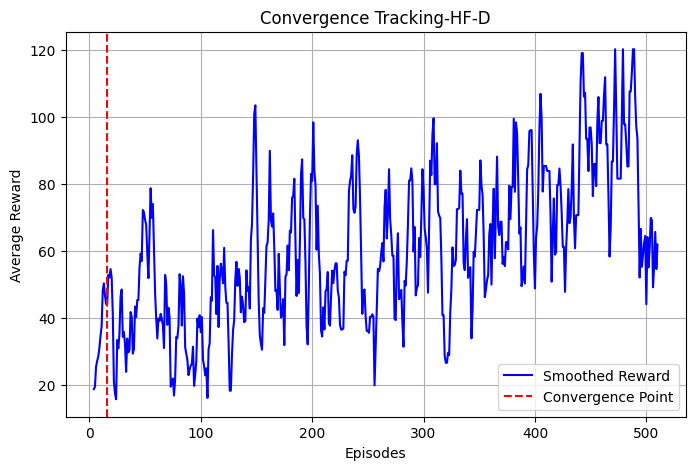

Time of Convergence of HF-D : 102.494975 timesteps


In [9]:
convergence_time = calculate_convergence_time()
print(f"Time of Convergence of HF-D : {convergence_time} timesteps" if convergence_time else "No clear convergence found.")